### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
import time
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [2]:
from keras.models import load_model

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [5]:
Time_matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence


Tracking the following state-actions pairs:
1. state: (3,14,5), action: (3,1)
2. state: (1,8,2), action: (4,2)
3. state: (2,10,3), action: (1,4)

In [6]:
# state tracking:
states_track = [(3,14,5),(1,8,2),(2,10,3)]
actions_track = [(3,1),(4,2),(1,4)]

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size, states_track, actions_track):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01 
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 0.0009
        self.epsilon_min = 0.001
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        # tracking state, action for convergence
        self.state_tracking_1, self.state_tracking_2, self.state_tracking_3 = [], [], []
        
        self.states_to_track = []
        for state in states_track:
            self.states_to_track.append(np.array(env.state_encod_arch2(state)).reshape(1, self.state_size))
        
        self.actions_track_index = []
        for action in actions_track:
            self.actions_track_index.append(env.action_space.index(action))
        

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets    
        
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation= 'relu', kernel_initializer= 'he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        
        return model


    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment    
        
        possible_actions_index, actions = env.requests(state)
        
        z = np.random.random()
        
        if z > self.epsilon:  #Exploitation
            state = np.array(env.state_encod_arch2(state)).reshape(1,self.state_size)
            q_values = self.model.predict(state)
            q_values_possible = np.array([q_values[0][i] for i in possible_actions_index])
            q_max_index = np.argmax(q_values_possible)
            
            return possible_actions_index[q_max_index]
        
        else:    #Exploration
            return random.randrange(self.action_size)

    def append_sample(self, state, action, reward, next_state, terminal_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, terminal_state = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state2 = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch2(next_state)
                terminal_state.append(terminal_state2)
                
                # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            target_q_net = self.model.predict(update_output)
                
            # 3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
    
                if terminal_state[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.amax(target_q_net[i])
            
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
            
    def save(self, name):
#         self.model.save_weights(name)
        self.model.save(name)
        
    def save_state_tracking(self):
        q_val_1 = self.model.predict(self.states_to_track[0])
        q_val_2 = self.model.predict(self.states_to_track[1])
        q_val_3 = self.model.predict(self.states_to_track[2])
        
        self.state_tracking_1.append(q_val_1[0][self.actions_track_index[0]])
        self.state_tracking_2.append(q_val_1[0][self.actions_track_index[1]])
        self.state_tracking_3.append(q_val_1[0][self.actions_track_index[2]])
        
    #Defining a function to save the Q-dictionary as a pickle file
    def save_obj(self, name):
        obj = self.model.weights
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [8]:
#Initializing necessary variables
Episodes = 10000
max_run_time = 24*30
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1

### DQN block

In [9]:
start_time = time.time() #to calculate the time of each episode
#rewards_tracked = []
rewards_per_episode =[]
episodes = []

#Getting info from CabDriver to invoke DQNAgent object
env = CabDriver()
action_space, state_space, state = env.reset()
state_size = m+t+d
action_size = len(action_space)
dqn_agent = DQNAgent(state_size, action_size, states_track, actions_track)

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    terminal_state = False
    reward_this_episode = 0
    
    env = CabDriver()
    action_space, state_space, state = env.reset()
    init_state = state
    total_time = 0 #time drive time for this episode
    
    while not (terminal_state):
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action_index = dqn_agent.get_action(state)
        action = env.action_space[action_index]
        
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, action, Time_matrix)
        next_state = env.next_state_func(state, action, Time_matrix)
        
        #calculate the time taken as the max time is 24*30 hrs.
        time_for_step = env.calc_total_time(state, action, Time_matrix)
        total_time += time_for_step
        if total_time < max_run_time:
            # 3. Append the experience to the memory
            dqn_agent.append_sample(state, action_index, reward, next_state, terminal_state)
            # 4. Train the model by calling function dqn_agent.train_model
            dqn_agent.train_model()
            # 5. Keep a track of rewards, Q-values, loss
            reward_this_episode += reward
            state = next_state
        else:
            terminal_state = True
        
    rewards_per_episode.append(reward_this_episode)
    episodes.append(episode)

    #set the epsilon value
    dqn_agent.epsilon = dqn_agent.epsilon_min + (dqn_agent.epsilon_max - dqn_agent.epsilon_min) * np.exp(dqn_agent.epsilon_decay * episode)

    if episode % 5 == 0:
        print('Episode ',episode, 
              '\tInitial State: ', init_state, 
              '\tEpisode Reward: ',reward_this_episode, 
              '\tTotal Ride Time: ', total_time)
        dqn_agent.save_state_tracking()

    if episode % 1000 == 0:
        dqn_agent.save('CabDriver_DQN_Model.h5')

end_time = time.time()
print('Elapsed time: ', (end_time-start_time))

2022-02-14 11:55:40.601147: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-02-14 11:55:40.601238: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hal9000
2022-02-14 11:55:40.601251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hal9000
2022-02-14 11:55:40.601483: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-02-14 11:55:40.601537: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-02-14 11:55:40.601548: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-02-14 11:55:40.602031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical oper

Episode  0 	Initial State:  (1, 2, 2) 	Episode Reward:  -382 	Total Ride Time:  729
Episode  5 	Initial State:  (3, 2, 0) 	Episode Reward:  102 	Total Ride Time:  720
Episode  10 	Initial State:  (3, 7, 3) 	Episode Reward:  -40 	Total Ride Time:  725
Episode  15 	Initial State:  (0, 8, 4) 	Episode Reward:  -291 	Total Ride Time:  722
Episode  20 	Initial State:  (0, 7, 5) 	Episode Reward:  -75 	Total Ride Time:  725
Episode  25 	Initial State:  (2, 10, 3) 	Episode Reward:  -197 	Total Ride Time:  723
Episode  30 	Initial State:  (2, 9, 5) 	Episode Reward:  -152 	Total Ride Time:  720
Episode  35 	Initial State:  (4, 23, 2) 	Episode Reward:  -85 	Total Ride Time:  720
Episode  40 	Initial State:  (2, 5, 5) 	Episode Reward:  -252 	Total Ride Time:  729
Episode  45 	Initial State:  (1, 11, 1) 	Episode Reward:  -13 	Total Ride Time:  730
Episode  50 	Initial State:  (4, 15, 5) 	Episode Reward:  257 	Total Ride Time:  721
Episode  55 	Initial State:  (1, 17, 2) 	Episode Reward:  -244 	Total

Episode  480 	Initial State:  (2, 14, 6) 	Episode Reward:  116 	Total Ride Time:  724
Episode  485 	Initial State:  (4, 15, 6) 	Episode Reward:  -4 	Total Ride Time:  725
Episode  490 	Initial State:  (4, 17, 0) 	Episode Reward:  26 	Total Ride Time:  721
Episode  495 	Initial State:  (2, 6, 4) 	Episode Reward:  -143 	Total Ride Time:  722
Episode  500 	Initial State:  (1, 2, 3) 	Episode Reward:  69 	Total Ride Time:  723
Episode  505 	Initial State:  (3, 6, 2) 	Episode Reward:  114 	Total Ride Time:  724
Episode  510 	Initial State:  (3, 18, 4) 	Episode Reward:  -180 	Total Ride Time:  720
Episode  515 	Initial State:  (2, 15, 0) 	Episode Reward:  -26 	Total Ride Time:  724
Episode  520 	Initial State:  (2, 22, 0) 	Episode Reward:  -295 	Total Ride Time:  721
Episode  525 	Initial State:  (3, 15, 3) 	Episode Reward:  -65 	Total Ride Time:  724
Episode  530 	Initial State:  (4, 12, 2) 	Episode Reward:  -57 	Total Ride Time:  724
Episode  535 	Initial State:  (1, 8, 1) 	Episode Reward: 

Episode  960 	Initial State:  (1, 16, 4) 	Episode Reward:  68 	Total Ride Time:  723
Episode  965 	Initial State:  (1, 15, 1) 	Episode Reward:  -15 	Total Ride Time:  727
Episode  970 	Initial State:  (3, 10, 4) 	Episode Reward:  213 	Total Ride Time:  720
Episode  975 	Initial State:  (3, 20, 4) 	Episode Reward:  -55 	Total Ride Time:  720
Episode  980 	Initial State:  (2, 8, 5) 	Episode Reward:  -209 	Total Ride Time:  720
Episode  985 	Initial State:  (3, 2, 3) 	Episode Reward:  -119 	Total Ride Time:  721
Episode  990 	Initial State:  (0, 22, 0) 	Episode Reward:  132 	Total Ride Time:  722
Episode  995 	Initial State:  (3, 11, 3) 	Episode Reward:  132 	Total Ride Time:  727
Episode  1000 	Initial State:  (2, 13, 2) 	Episode Reward:  -229 	Total Ride Time:  721
Episode  1005 	Initial State:  (3, 12, 4) 	Episode Reward:  -31 	Total Ride Time:  726
Episode  1010 	Initial State:  (4, 3, 2) 	Episode Reward:  46 	Total Ride Time:  720
Episode  1015 	Initial State:  (0, 9, 0) 	Episode Rew

Episode  1435 	Initial State:  (2, 16, 1) 	Episode Reward:  87 	Total Ride Time:  722
Episode  1440 	Initial State:  (0, 6, 3) 	Episode Reward:  93 	Total Ride Time:  723
Episode  1445 	Initial State:  (2, 7, 3) 	Episode Reward:  5 	Total Ride Time:  720
Episode  1450 	Initial State:  (2, 8, 5) 	Episode Reward:  85 	Total Ride Time:  720
Episode  1455 	Initial State:  (4, 21, 2) 	Episode Reward:  176 	Total Ride Time:  725
Episode  1460 	Initial State:  (2, 2, 4) 	Episode Reward:  361 	Total Ride Time:  721
Episode  1465 	Initial State:  (2, 18, 6) 	Episode Reward:  -111 	Total Ride Time:  722
Episode  1470 	Initial State:  (3, 6, 3) 	Episode Reward:  -92 	Total Ride Time:  722
Episode  1475 	Initial State:  (4, 11, 6) 	Episode Reward:  -58 	Total Ride Time:  721
Episode  1480 	Initial State:  (4, 0, 6) 	Episode Reward:  -283 	Total Ride Time:  732
Episode  1485 	Initial State:  (0, 20, 2) 	Episode Reward:  156 	Total Ride Time:  723
Episode  1490 	Initial State:  (4, 5, 0) 	Episode Re

Episode  1910 	Initial State:  (1, 13, 5) 	Episode Reward:  -77 	Total Ride Time:  721
Episode  1915 	Initial State:  (4, 1, 4) 	Episode Reward:  9 	Total Ride Time:  720
Episode  1920 	Initial State:  (2, 1, 1) 	Episode Reward:  370 	Total Ride Time:  725
Episode  1925 	Initial State:  (1, 4, 6) 	Episode Reward:  111 	Total Ride Time:  720
Episode  1930 	Initial State:  (1, 6, 4) 	Episode Reward:  356 	Total Ride Time:  728
Episode  1935 	Initial State:  (4, 8, 6) 	Episode Reward:  -73 	Total Ride Time:  728
Episode  1940 	Initial State:  (1, 11, 5) 	Episode Reward:  73 	Total Ride Time:  722
Episode  1945 	Initial State:  (1, 6, 6) 	Episode Reward:  59 	Total Ride Time:  722
Episode  1950 	Initial State:  (2, 23, 4) 	Episode Reward:  -31 	Total Ride Time:  727
Episode  1955 	Initial State:  (4, 0, 2) 	Episode Reward:  -156 	Total Ride Time:  720
Episode  1960 	Initial State:  (3, 11, 0) 	Episode Reward:  41 	Total Ride Time:  721
Episode  1965 	Initial State:  (2, 2, 5) 	Episode Rewa

Episode  2385 	Initial State:  (0, 4, 4) 	Episode Reward:  89 	Total Ride Time:  720
Episode  2390 	Initial State:  (1, 9, 0) 	Episode Reward:  7 	Total Ride Time:  725
Episode  2395 	Initial State:  (3, 8, 5) 	Episode Reward:  -55 	Total Ride Time:  727
Episode  2400 	Initial State:  (4, 13, 3) 	Episode Reward:  442 	Total Ride Time:  723
Episode  2405 	Initial State:  (2, 13, 0) 	Episode Reward:  -67 	Total Ride Time:  721
Episode  2410 	Initial State:  (3, 1, 6) 	Episode Reward:  175 	Total Ride Time:  721
Episode  2415 	Initial State:  (0, 21, 1) 	Episode Reward:  -337 	Total Ride Time:  720
Episode  2420 	Initial State:  (3, 2, 0) 	Episode Reward:  56 	Total Ride Time:  721
Episode  2425 	Initial State:  (1, 14, 2) 	Episode Reward:  77 	Total Ride Time:  728
Episode  2430 	Initial State:  (2, 22, 4) 	Episode Reward:  -250 	Total Ride Time:  726
Episode  2435 	Initial State:  (1, 21, 0) 	Episode Reward:  -55 	Total Ride Time:  722
Episode  2440 	Initial State:  (3, 12, 2) 	Episode 

Episode  2860 	Initial State:  (4, 6, 4) 	Episode Reward:  -138 	Total Ride Time:  727
Episode  2865 	Initial State:  (2, 18, 3) 	Episode Reward:  94 	Total Ride Time:  721
Episode  2870 	Initial State:  (2, 2, 1) 	Episode Reward:  118 	Total Ride Time:  725
Episode  2875 	Initial State:  (4, 10, 5) 	Episode Reward:  -570 	Total Ride Time:  725
Episode  2880 	Initial State:  (1, 18, 6) 	Episode Reward:  -555 	Total Ride Time:  730
Episode  2885 	Initial State:  (4, 0, 6) 	Episode Reward:  56 	Total Ride Time:  723
Episode  2890 	Initial State:  (0, 19, 5) 	Episode Reward:  -452 	Total Ride Time:  720
Episode  2895 	Initial State:  (4, 1, 5) 	Episode Reward:  -167 	Total Ride Time:  726
Episode  2900 	Initial State:  (2, 14, 2) 	Episode Reward:  68 	Total Ride Time:  720
Episode  2905 	Initial State:  (4, 18, 2) 	Episode Reward:  44 	Total Ride Time:  723
Episode  2910 	Initial State:  (2, 13, 5) 	Episode Reward:  -220 	Total Ride Time:  725
Episode  2915 	Initial State:  (3, 19, 5) 	Ep

Episode  3335 	Initial State:  (4, 3, 5) 	Episode Reward:  -222 	Total Ride Time:  722
Episode  3340 	Initial State:  (4, 22, 6) 	Episode Reward:  122 	Total Ride Time:  730
Episode  3345 	Initial State:  (2, 15, 6) 	Episode Reward:  173 	Total Ride Time:  725
Episode  3350 	Initial State:  (0, 13, 5) 	Episode Reward:  -76 	Total Ride Time:  727
Episode  3355 	Initial State:  (3, 17, 2) 	Episode Reward:  -23 	Total Ride Time:  722
Episode  3360 	Initial State:  (1, 11, 5) 	Episode Reward:  -122 	Total Ride Time:  721
Episode  3365 	Initial State:  (0, 13, 5) 	Episode Reward:  -69 	Total Ride Time:  726
Episode  3370 	Initial State:  (3, 14, 5) 	Episode Reward:  -49 	Total Ride Time:  736
Episode  3375 	Initial State:  (0, 1, 1) 	Episode Reward:  121 	Total Ride Time:  722
Episode  3380 	Initial State:  (2, 7, 5) 	Episode Reward:  -97 	Total Ride Time:  726
Episode  3385 	Initial State:  (4, 3, 0) 	Episode Reward:  -46 	Total Ride Time:  721
Episode  3390 	Initial State:  (1, 7, 6) 	Epi

Episode  3810 	Initial State:  (2, 2, 0) 	Episode Reward:  147 	Total Ride Time:  724
Episode  3815 	Initial State:  (0, 14, 3) 	Episode Reward:  -130 	Total Ride Time:  721
Episode  3820 	Initial State:  (0, 19, 0) 	Episode Reward:  -304 	Total Ride Time:  722
Episode  3825 	Initial State:  (2, 9, 2) 	Episode Reward:  -148 	Total Ride Time:  721
Episode  3830 	Initial State:  (1, 21, 0) 	Episode Reward:  422 	Total Ride Time:  724
Episode  3835 	Initial State:  (1, 15, 2) 	Episode Reward:  -175 	Total Ride Time:  726
Episode  3840 	Initial State:  (1, 12, 4) 	Episode Reward:  -123 	Total Ride Time:  721
Episode  3845 	Initial State:  (3, 2, 5) 	Episode Reward:  47 	Total Ride Time:  733
Episode  3850 	Initial State:  (0, 13, 3) 	Episode Reward:  -44 	Total Ride Time:  730
Episode  3855 	Initial State:  (1, 1, 6) 	Episode Reward:  -219 	Total Ride Time:  724
Episode  3860 	Initial State:  (3, 13, 6) 	Episode Reward:  -133 	Total Ride Time:  731
Episode  3865 	Initial State:  (1, 7, 4) 

Episode  4285 	Initial State:  (0, 6, 5) 	Episode Reward:  -53 	Total Ride Time:  729
Episode  4290 	Initial State:  (1, 6, 4) 	Episode Reward:  -206 	Total Ride Time:  720
Episode  4295 	Initial State:  (2, 1, 3) 	Episode Reward:  110 	Total Ride Time:  722
Episode  4300 	Initial State:  (3, 17, 6) 	Episode Reward:  -370 	Total Ride Time:  723
Episode  4305 	Initial State:  (3, 16, 5) 	Episode Reward:  1 	Total Ride Time:  731
Episode  4310 	Initial State:  (2, 5, 3) 	Episode Reward:  262 	Total Ride Time:  720
Episode  4315 	Initial State:  (2, 0, 4) 	Episode Reward:  -257 	Total Ride Time:  720
Episode  4320 	Initial State:  (3, 0, 0) 	Episode Reward:  -188 	Total Ride Time:  728
Episode  4325 	Initial State:  (3, 10, 2) 	Episode Reward:  198 	Total Ride Time:  726
Episode  4330 	Initial State:  (4, 4, 0) 	Episode Reward:  123 	Total Ride Time:  725
Episode  4335 	Initial State:  (2, 8, 1) 	Episode Reward:  253 	Total Ride Time:  728
Episode  4340 	Initial State:  (4, 10, 6) 	Episod

Episode  4760 	Initial State:  (4, 14, 4) 	Episode Reward:  28 	Total Ride Time:  725
Episode  4765 	Initial State:  (2, 14, 4) 	Episode Reward:  70 	Total Ride Time:  730
Episode  4770 	Initial State:  (3, 1, 3) 	Episode Reward:  -233 	Total Ride Time:  727
Episode  4775 	Initial State:  (4, 14, 2) 	Episode Reward:  334 	Total Ride Time:  724
Episode  4780 	Initial State:  (3, 22, 4) 	Episode Reward:  6 	Total Ride Time:  732
Episode  4785 	Initial State:  (3, 15, 2) 	Episode Reward:  -310 	Total Ride Time:  724
Episode  4790 	Initial State:  (3, 6, 5) 	Episode Reward:  -157 	Total Ride Time:  728
Episode  4795 	Initial State:  (2, 10, 5) 	Episode Reward:  60 	Total Ride Time:  723
Episode  4800 	Initial State:  (4, 14, 5) 	Episode Reward:  3 	Total Ride Time:  720
Episode  4805 	Initial State:  (1, 10, 2) 	Episode Reward:  136 	Total Ride Time:  720
Episode  4810 	Initial State:  (1, 1, 2) 	Episode Reward:  57 	Total Ride Time:  723
Episode  4815 	Initial State:  (0, 9, 1) 	Episode R

Episode  5235 	Initial State:  (1, 5, 6) 	Episode Reward:  230 	Total Ride Time:  723
Episode  5240 	Initial State:  (3, 14, 1) 	Episode Reward:  33 	Total Ride Time:  721
Episode  5245 	Initial State:  (1, 9, 1) 	Episode Reward:  -184 	Total Ride Time:  724
Episode  5250 	Initial State:  (4, 14, 6) 	Episode Reward:  41 	Total Ride Time:  724
Episode  5255 	Initial State:  (4, 9, 6) 	Episode Reward:  -45 	Total Ride Time:  723
Episode  5260 	Initial State:  (3, 8, 1) 	Episode Reward:  -49 	Total Ride Time:  726
Episode  5265 	Initial State:  (0, 8, 1) 	Episode Reward:  207 	Total Ride Time:  720
Episode  5270 	Initial State:  (3, 6, 2) 	Episode Reward:  222 	Total Ride Time:  733
Episode  5275 	Initial State:  (1, 10, 1) 	Episode Reward:  -179 	Total Ride Time:  728
Episode  5280 	Initial State:  (1, 14, 0) 	Episode Reward:  5 	Total Ride Time:  723
Episode  5285 	Initial State:  (1, 3, 6) 	Episode Reward:  92 	Total Ride Time:  732
Episode  5290 	Initial State:  (2, 10, 0) 	Episode Re

Episode  5710 	Initial State:  (1, 13, 0) 	Episode Reward:  44 	Total Ride Time:  723
Episode  5715 	Initial State:  (4, 11, 1) 	Episode Reward:  123 	Total Ride Time:  720
Episode  5720 	Initial State:  (1, 20, 5) 	Episode Reward:  33 	Total Ride Time:  732
Episode  5725 	Initial State:  (4, 10, 6) 	Episode Reward:  -91 	Total Ride Time:  723
Episode  5730 	Initial State:  (4, 7, 0) 	Episode Reward:  87 	Total Ride Time:  721
Episode  5735 	Initial State:  (2, 14, 0) 	Episode Reward:  116 	Total Ride Time:  722
Episode  5740 	Initial State:  (3, 16, 4) 	Episode Reward:  -94 	Total Ride Time:  734
Episode  5745 	Initial State:  (2, 3, 6) 	Episode Reward:  -360 	Total Ride Time:  722
Episode  5750 	Initial State:  (2, 6, 0) 	Episode Reward:  -304 	Total Ride Time:  723
Episode  5755 	Initial State:  (3, 9, 3) 	Episode Reward:  -40 	Total Ride Time:  722
Episode  5760 	Initial State:  (2, 8, 0) 	Episode Reward:  41 	Total Ride Time:  722
Episode  5765 	Initial State:  (2, 23, 0) 	Episode

Episode  6185 	Initial State:  (0, 4, 0) 	Episode Reward:  377 	Total Ride Time:  725
Episode  6190 	Initial State:  (1, 5, 6) 	Episode Reward:  131 	Total Ride Time:  720
Episode  6195 	Initial State:  (0, 17, 1) 	Episode Reward:  -36 	Total Ride Time:  725
Episode  6200 	Initial State:  (3, 12, 1) 	Episode Reward:  -232 	Total Ride Time:  720
Episode  6205 	Initial State:  (1, 17, 4) 	Episode Reward:  -201 	Total Ride Time:  731
Episode  6210 	Initial State:  (1, 23, 1) 	Episode Reward:  -112 	Total Ride Time:  732
Episode  6215 	Initial State:  (1, 18, 3) 	Episode Reward:  -14 	Total Ride Time:  723
Episode  6220 	Initial State:  (4, 19, 2) 	Episode Reward:  -170 	Total Ride Time:  725
Episode  6225 	Initial State:  (1, 19, 2) 	Episode Reward:  -3 	Total Ride Time:  722
Episode  6230 	Initial State:  (4, 15, 1) 	Episode Reward:  -242 	Total Ride Time:  725
Episode  6235 	Initial State:  (4, 3, 4) 	Episode Reward:  -143 	Total Ride Time:  728
Episode  6240 	Initial State:  (0, 18, 5)

Episode  6660 	Initial State:  (3, 2, 2) 	Episode Reward:  24 	Total Ride Time:  727
Episode  6665 	Initial State:  (2, 18, 3) 	Episode Reward:  85 	Total Ride Time:  723
Episode  6670 	Initial State:  (4, 18, 1) 	Episode Reward:  -314 	Total Ride Time:  724
Episode  6675 	Initial State:  (4, 18, 4) 	Episode Reward:  119 	Total Ride Time:  727
Episode  6680 	Initial State:  (1, 6, 4) 	Episode Reward:  246 	Total Ride Time:  724
Episode  6685 	Initial State:  (3, 3, 0) 	Episode Reward:  -197 	Total Ride Time:  725
Episode  6690 	Initial State:  (1, 22, 5) 	Episode Reward:  -215 	Total Ride Time:  737
Episode  6695 	Initial State:  (2, 20, 3) 	Episode Reward:  106 	Total Ride Time:  721
Episode  6700 	Initial State:  (4, 8, 2) 	Episode Reward:  -17 	Total Ride Time:  721
Episode  6705 	Initial State:  (4, 3, 3) 	Episode Reward:  63 	Total Ride Time:  726
Episode  6710 	Initial State:  (2, 10, 4) 	Episode Reward:  -158 	Total Ride Time:  720
Episode  6715 	Initial State:  (0, 7, 0) 	Episo

Episode  7135 	Initial State:  (0, 3, 1) 	Episode Reward:  101 	Total Ride Time:  724
Episode  7140 	Initial State:  (3, 10, 2) 	Episode Reward:  -80 	Total Ride Time:  725
Episode  7145 	Initial State:  (4, 12, 3) 	Episode Reward:  -204 	Total Ride Time:  721
Episode  7150 	Initial State:  (2, 20, 2) 	Episode Reward:  -157 	Total Ride Time:  721
Episode  7155 	Initial State:  (1, 11, 0) 	Episode Reward:  -99 	Total Ride Time:  722
Episode  7160 	Initial State:  (3, 18, 4) 	Episode Reward:  191 	Total Ride Time:  721
Episode  7165 	Initial State:  (1, 0, 3) 	Episode Reward:  -133 	Total Ride Time:  720
Episode  7170 	Initial State:  (2, 6, 0) 	Episode Reward:  11 	Total Ride Time:  732
Episode  7175 	Initial State:  (3, 5, 2) 	Episode Reward:  -181 	Total Ride Time:  725
Episode  7180 	Initial State:  (1, 15, 5) 	Episode Reward:  -34 	Total Ride Time:  732
Episode  7185 	Initial State:  (2, 2, 0) 	Episode Reward:  -130 	Total Ride Time:  721
Episode  7190 	Initial State:  (1, 20, 6) 	E

Episode  7610 	Initial State:  (1, 23, 1) 	Episode Reward:  -78 	Total Ride Time:  722
Episode  7615 	Initial State:  (3, 14, 4) 	Episode Reward:  -236 	Total Ride Time:  722
Episode  7620 	Initial State:  (2, 12, 0) 	Episode Reward:  -220 	Total Ride Time:  720
Episode  7625 	Initial State:  (2, 19, 4) 	Episode Reward:  43 	Total Ride Time:  725
Episode  7630 	Initial State:  (1, 10, 3) 	Episode Reward:  -73 	Total Ride Time:  731
Episode  7635 	Initial State:  (3, 22, 4) 	Episode Reward:  65 	Total Ride Time:  729
Episode  7640 	Initial State:  (3, 21, 0) 	Episode Reward:  119 	Total Ride Time:  725
Episode  7645 	Initial State:  (3, 19, 0) 	Episode Reward:  492 	Total Ride Time:  727
Episode  7650 	Initial State:  (3, 10, 0) 	Episode Reward:  67 	Total Ride Time:  720
Episode  7655 	Initial State:  (1, 20, 2) 	Episode Reward:  96 	Total Ride Time:  729
Episode  7660 	Initial State:  (1, 6, 4) 	Episode Reward:  -105 	Total Ride Time:  721
Episode  7665 	Initial State:  (0, 19, 3) 	Ep

Episode  8085 	Initial State:  (1, 11, 3) 	Episode Reward:  14 	Total Ride Time:  723
Episode  8090 	Initial State:  (0, 17, 5) 	Episode Reward:  -125 	Total Ride Time:  724
Episode  8095 	Initial State:  (0, 4, 4) 	Episode Reward:  142 	Total Ride Time:  720
Episode  8100 	Initial State:  (1, 3, 2) 	Episode Reward:  52 	Total Ride Time:  723
Episode  8105 	Initial State:  (3, 21, 0) 	Episode Reward:  340 	Total Ride Time:  721
Episode  8110 	Initial State:  (1, 15, 3) 	Episode Reward:  -82 	Total Ride Time:  720
Episode  8115 	Initial State:  (0, 20, 2) 	Episode Reward:  -60 	Total Ride Time:  726
Episode  8120 	Initial State:  (2, 6, 1) 	Episode Reward:  -93 	Total Ride Time:  730
Episode  8125 	Initial State:  (2, 17, 1) 	Episode Reward:  -17 	Total Ride Time:  720
Episode  8130 	Initial State:  (1, 8, 4) 	Episode Reward:  -130 	Total Ride Time:  723
Episode  8135 	Initial State:  (4, 23, 4) 	Episode Reward:  -82 	Total Ride Time:  727
Episode  8140 	Initial State:  (4, 6, 3) 	Episo

Episode  8560 	Initial State:  (2, 2, 0) 	Episode Reward:  -241 	Total Ride Time:  728
Episode  8565 	Initial State:  (3, 8, 0) 	Episode Reward:  92 	Total Ride Time:  725
Episode  8570 	Initial State:  (1, 21, 3) 	Episode Reward:  53 	Total Ride Time:  721
Episode  8575 	Initial State:  (0, 12, 6) 	Episode Reward:  239 	Total Ride Time:  721
Episode  8580 	Initial State:  (2, 12, 3) 	Episode Reward:  -1 	Total Ride Time:  720
Episode  8585 	Initial State:  (2, 0, 4) 	Episode Reward:  20 	Total Ride Time:  720
Episode  8590 	Initial State:  (2, 21, 5) 	Episode Reward:  14 	Total Ride Time:  721
Episode  8595 	Initial State:  (3, 22, 4) 	Episode Reward:  3 	Total Ride Time:  728
Episode  8600 	Initial State:  (0, 12, 2) 	Episode Reward:  -138 	Total Ride Time:  721
Episode  8605 	Initial State:  (0, 15, 5) 	Episode Reward:  242 	Total Ride Time:  721
Episode  8610 	Initial State:  (0, 1, 2) 	Episode Reward:  19 	Total Ride Time:  721
Episode  8615 	Initial State:  (4, 12, 4) 	Episode Re

Episode  9035 	Initial State:  (0, 18, 1) 	Episode Reward:  116 	Total Ride Time:  721
Episode  9040 	Initial State:  (2, 20, 4) 	Episode Reward:  118 	Total Ride Time:  722
Episode  9045 	Initial State:  (3, 14, 1) 	Episode Reward:  50 	Total Ride Time:  723
Episode  9050 	Initial State:  (1, 7, 0) 	Episode Reward:  211 	Total Ride Time:  724
Episode  9055 	Initial State:  (0, 8, 3) 	Episode Reward:  59 	Total Ride Time:  726
Episode  9060 	Initial State:  (3, 11, 1) 	Episode Reward:  -85 	Total Ride Time:  722
Episode  9065 	Initial State:  (2, 9, 2) 	Episode Reward:  6 	Total Ride Time:  722
Episode  9070 	Initial State:  (2, 9, 2) 	Episode Reward:  -265 	Total Ride Time:  724
Episode  9075 	Initial State:  (2, 14, 0) 	Episode Reward:  193 	Total Ride Time:  722
Episode  9080 	Initial State:  (2, 20, 6) 	Episode Reward:  -170 	Total Ride Time:  724
Episode  9085 	Initial State:  (2, 2, 1) 	Episode Reward:  -134 	Total Ride Time:  725
Episode  9090 	Initial State:  (2, 0, 4) 	Episode

Episode  9510 	Initial State:  (1, 10, 2) 	Episode Reward:  -387 	Total Ride Time:  720
Episode  9515 	Initial State:  (4, 15, 2) 	Episode Reward:  -48 	Total Ride Time:  726
Episode  9520 	Initial State:  (2, 8, 0) 	Episode Reward:  235 	Total Ride Time:  722
Episode  9525 	Initial State:  (3, 18, 0) 	Episode Reward:  32 	Total Ride Time:  720
Episode  9530 	Initial State:  (1, 14, 3) 	Episode Reward:  -104 	Total Ride Time:  723
Episode  9535 	Initial State:  (0, 5, 4) 	Episode Reward:  -98 	Total Ride Time:  730
Episode  9540 	Initial State:  (4, 12, 0) 	Episode Reward:  -157 	Total Ride Time:  725
Episode  9545 	Initial State:  (2, 1, 4) 	Episode Reward:  -181 	Total Ride Time:  723
Episode  9550 	Initial State:  (3, 8, 5) 	Episode Reward:  14 	Total Ride Time:  726
Episode  9555 	Initial State:  (4, 1, 6) 	Episode Reward:  -183 	Total Ride Time:  720
Episode  9560 	Initial State:  (4, 18, 6) 	Episode Reward:  -397 	Total Ride Time:  720
Episode  9565 	Initial State:  (1, 22, 6) 	E

Episode  9985 	Initial State:  (2, 13, 3) 	Episode Reward:  32 	Total Ride Time:  726
Episode  9990 	Initial State:  (2, 21, 3) 	Episode Reward:  -80 	Total Ride Time:  720
Episode  9995 	Initial State:  (0, 22, 1) 	Episode Reward:  -68 	Total Ride Time:  722
Elapsed time:  -101884.34758353233


In [10]:
dqn_agent.save('CabDriver_DQN_Model.h5') #h5 file
dqn_agent.save_obj('Model_Weights') #pickle file

### Tracking Convergence

In [11]:
model = load_model('CabDriver_DQN_Model.h5')

In [12]:
# Function to predict action for given state
def dqn_predict(state):
    state_size = m + t + d
    encoded_state = np.array(env.state_encod_arch2(state)).reshape(1, state_size)
    action_index = np.argmax(model.predict(encoded_state))
    action = action_space[action_index]
    print('Predicted Action for {0}: {1}'.format(state, action))

In [26]:
dqn_predict((3,14,1))

Predicted Action for (3, 14, 1): (0, 4)


In [20]:
dqn_agent.state_tracking_1[:5]

[456.18326, 230.37868, 324.5406, 341.3917, 329.2673]

In [21]:
dqn_agent.state_tracking_2[:5]

[536.39044, 227.74983, 303.32336, 328.5972, 310.89212]

In [25]:
dqn_agent.state_tracking_3[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]


    state: (3,14,5), action: (3,1)
    state: (1,8,2), action: (4,2)
    state: (2,10,3), action: (1,4)


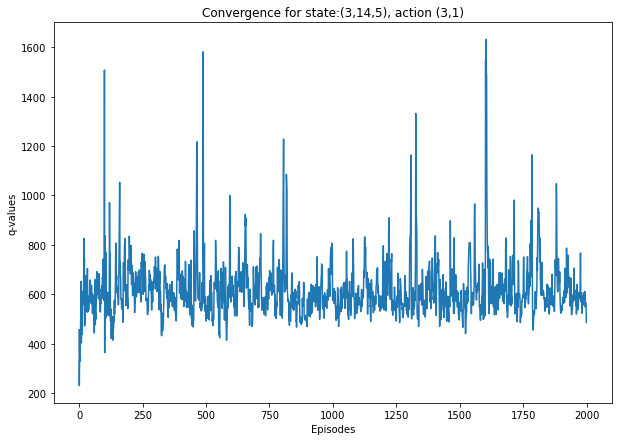

In [30]:
plt.figure(figsize=(10,7))
plt.title('Convergence for state:(3,14,5), action (3,1)')
x_axis = np.asarray(range(0, len(dqn_agent.state_tracking_1)))
plt.plot(x_axis,np.asarray(dqn_agent.state_tracking_1))
plt.ylabel('q-values')
plt.xlabel('Episodes')
plt.show()

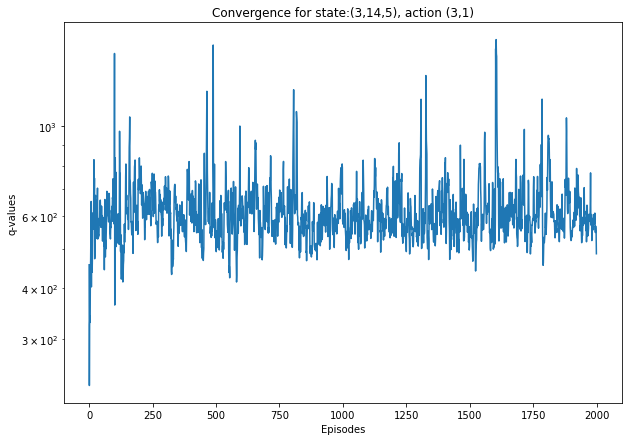

In [34]:
plt.figure(figsize=(10,7))
plt.title('Convergence for state:(3,14,5), action (3,1) (q-values on log scale)')
x_axis = np.asarray(range(0, len(dqn_agent.state_tracking_1)))
plt.yscale('log')
plt.plot(x_axis,np.asarray(dqn_agent.state_tracking_1))
plt.ylabel('q-values')
plt.xlabel('Episodes')
plt.show()

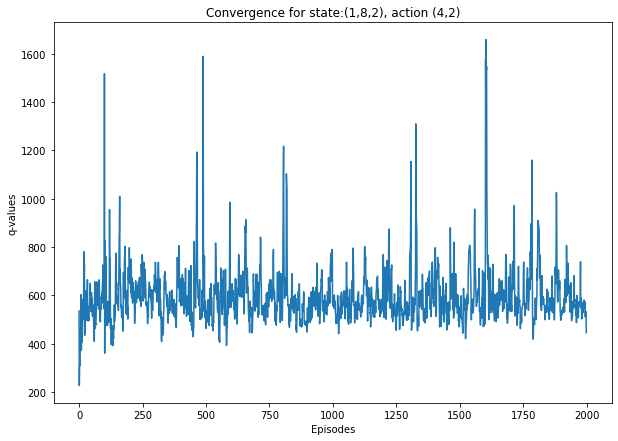

In [31]:
plt.figure(figsize=(10,7))
plt.title('Convergence for state:(1,8,2), action (4,2)')
x_axis = np.asarray(range(0, len(dqn_agent.state_tracking_2)))
plt.plot(x_axis,np.asarray(dqn_agent.state_tracking_2))
plt.ylabel('q-values')
plt.xlabel('Episodes')
plt.show()

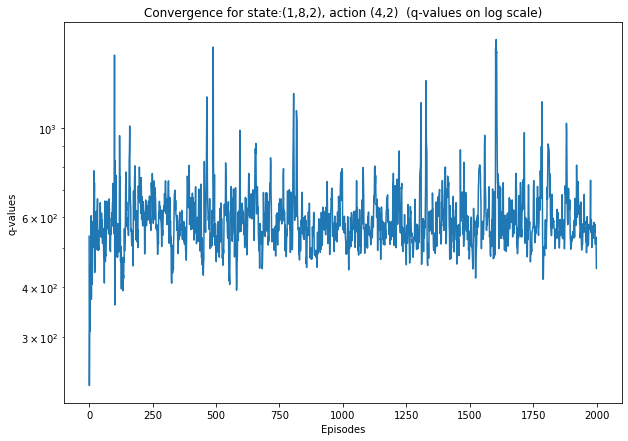

In [35]:
plt.figure(figsize=(10,7))
plt.title('Convergence for state:(1,8,2), action (4,2)  (q-values on log scale)')
x_axis = np.asarray(range(0, len(dqn_agent.state_tracking_2)))
plt.yscale('log')
plt.plot(x_axis,np.asarray(dqn_agent.state_tracking_2))
plt.ylabel('q-values')
plt.xlabel('Episodes')
plt.show()

In [33]:
# plt.figure(figsize=(10,7))
# plt.title('Convergence for state:(2,10,3), action (1,4)')
# x_axis = np.asarray(range(0, len(dqn_agent.state_tracking_3)))
# plt.plot(x_axis,np.asarray(dqn_agent.state_tracking_3))
# plt.ylabel('q-values')
# plt.xlabel('Episodes')
# plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [36]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

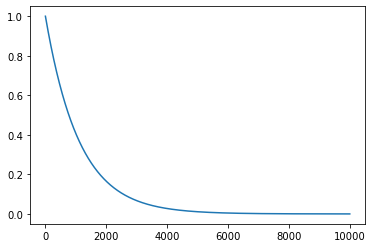

In [37]:
plt.plot(time, epsilon)
plt.show()